In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

In [2]:

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self,x):
        return self.encoder(x)

    def decode(self,x):
        return self.decoder(x)

In [3]:
def load_mnist_data(normal_digit=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1)) 
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    train_mask = train_dataset.targets == normal_digit
    train_data = train_dataset.data[train_mask]
    train_targets = train_dataset.targets[train_mask]
    
    train_dataset.data = train_data
    train_dataset.targets = train_targets
    
    return train_dataset, test_dataset

In [4]:
def train_autoencoder(model, train_loader, val_loader=None, num_epochs=50, device='cuda', patience=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.to(device)

            output = model(img)
            loss = criterion(output, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        
        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    img, _ = data
                    img = img.to(device)
                    output = model(img)
                    val_loss += criterion(output, img).item()
            
            avg_val_loss = val_loss / len(val_loader)
            model.train()
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.6f}')
        else:
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}')

In [5]:
def compute_reconstruction_errors(model, data_loader, device):
    model.eval()
    reconstruction_errors = []
    labels = []
    
    with torch.no_grad():
        for data in data_loader:
            img, label = data
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            error = torch.mean((output - img) ** 2, dim=1).cpu().numpy()
            reconstruction_errors.extend(error)
            labels.extend(label.cpu().numpy())
    
    return np.array(reconstruction_errors), np.array(labels)

In [6]:
def plot_error_distribution(errors_normal, errors_anomaly):
    plt.figure(figsize=(10, 6))
    plt.hist(errors_normal, bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(errors_anomaly, bins=50, alpha=0.5, label='Anomaly', density=True)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.savefig('reconstruction_errors.png')
    plt.show()
    plt.close()
    

In [7]:
def train_and_evaluate(latent_dim, train_loader, test_loader, input_dim=784,num_epochs=50, normal_digit=5, device='cuda'):

    model = AutoEncoder(input_dim, latent_dim).to(device)
    train_autoencoder(model, train_loader, num_epochs, device)

    test_errors, test_labels = compute_reconstruction_errors(model, test_loader, device)
    
    true_labels = (test_labels != normal_digit).astype(int)
    fpr, tpr, _ = roc_curve(true_labels, test_errors)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc, test_errors, test_labels


In [8]:
def plot_roc_curves(results):
    plt.figure(figsize=(10, 6))
    
    for latent_dim, (fpr, tpr, roc_auc, _) in results.items():
        plt.plot(fpr, tpr, label=f'Latent dim {latent_dim} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Latent Dimensions')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()
    plt.close()

In [9]:
def visualize_reconstructions(model, test_loader, normal_digit, device, num_examples=10):
    model.eval()
    
    normal_examples = []
    normal_reconstructions = []
    anomaly_examples = []
    anomaly_reconstructions = []
    
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            img = img.to(device)
            reconstructed = model(img)
            
            # Store normal examples (digit 2)
            normal_mask = label == normal_digit
            if normal_mask.any() and len(normal_examples) < num_examples:
                idx = normal_mask.nonzero()[0]
                normal_examples.append(img[idx].cpu())
                normal_reconstructions.append(reconstructed[idx].cpu())
            
            # Store anomaly examples (non-2)
            anomaly_mask = label != normal_digit
            if anomaly_mask.any() and len(anomaly_examples) < num_examples:
                idx = anomaly_mask.nonzero()[0]
                anomaly_examples.append(img[idx].cpu())
                anomaly_reconstructions.append(reconstructed[idx].cpu())
            
            if len(normal_examples) >= num_examples and len(anomaly_examples) >= num_examples:
                break
    
    fig, axes = plt.subplots(4, num_examples, figsize=(2*num_examples, 8))
    
    for i in range(num_examples):
        # Plot normal examples
        axes[0, i].imshow(normal_examples[i].view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original\nNormal (2)')
            
        axes[1, i].imshow(normal_reconstructions[i].view(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed\nNormal (2)')
            
        # Plot anomaly examples
        axes[2, i].imshow(anomaly_examples[i].view(28, 28), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Original\nAnomaly (non-2)')
            
        axes[3, i].imshow(anomaly_reconstructions[i].view(28, 28), cmap='gray')
        axes[3, i].axis('off')
        if i == 0:
            axes[3, i].set_title('Reconstructed\nAnomaly (non-2)')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    return fig

In [10]:

def select_threshold(errors_normal, errors_anomaly):
    threshold = (np.mean(errors_normal) + np.mean(errors_anomaly)) / 2
    return threshold

In [11]:

def evaluate_performance(test_errors, test_labels, normal_digit, threshold):
    true_labels = (test_labels != normal_digit).astype(int)
    pred_labels = (test_errors > threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')
    
    return precision, recall, f1

In [18]:
def train_and_evaluate(latent_dim, train_loader, test_loader, input_dim=784, num_epochs=50, normal_digit=5, device='cuda'):
    train_size = int(0.8 * len(train_loader.dataset))
    val_size = len(train_loader.dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_loader.dataset, [train_size, val_size]
    )
    
    train_loader_split = DataLoader(train_dataset, batch_size=train_loader.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=train_loader.batch_size, shuffle=False)

    model = AutoEncoder(input_dim, latent_dim).to(device)
    train_autoencoder(model, train_loader_split, val_loader, num_epochs, device)

    test_errors, test_labels = compute_reconstruction_errors(model, test_loader, device)
    
    normal_errors = test_errors[test_labels == normal_digit]
    anomaly_errors = test_errors[test_labels != normal_digit]
    threshold = select_threshold(normal_errors, anomaly_errors)
    
    precision, recall, f1 = evaluate_performance(test_errors, test_labels, normal_digit, threshold)
    print(f"\nPerformance metrics for latent_dim={latent_dim}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Threshold: {threshold:.4f}")
    
    true_labels = (test_labels != normal_digit).astype(int)
    fpr, tpr, _ = roc_curve(true_labels, test_errors)
    roc_auc = auc(fpr, tpr)
    
    fig = visualize_reconstructions(model, test_loader, normal_digit, device, num_examples=5)
    plt.savefig(f'reconstructions_dim_{latent_dim}.png')
    plt.close()
    
    return fpr, tpr, roc_auc, test_errors, test_labels, (precision, recall, f1, threshold)

In [13]:
torch.manual_seed(42)

normal_digit = 2
input_dim = 784
latent_dim = 32
batch_size = 64
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
train_dataset, test_dataset = load_mnist_data(normal_digit)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 58.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.60MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




Training model with latent dimension: 16
Epoch [10/50], Loss: 0.029608
Epoch [20/50], Loss: 0.022280
Epoch [30/50], Loss: 0.017075
Epoch [40/50], Loss: 0.014458
Epoch [50/50], Loss: 0.012649

Performance metrics for latent_dim=16:
Precision: 0.9943
Recall: 0.7914
F1-score: 0.8813
Threshold: 0.0357


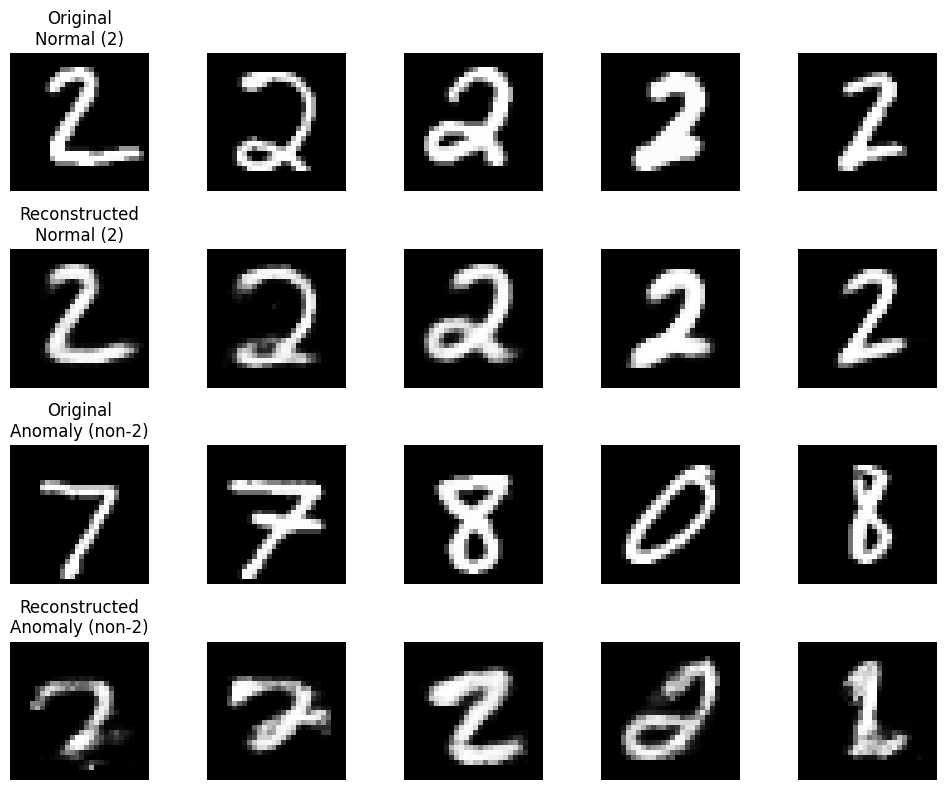

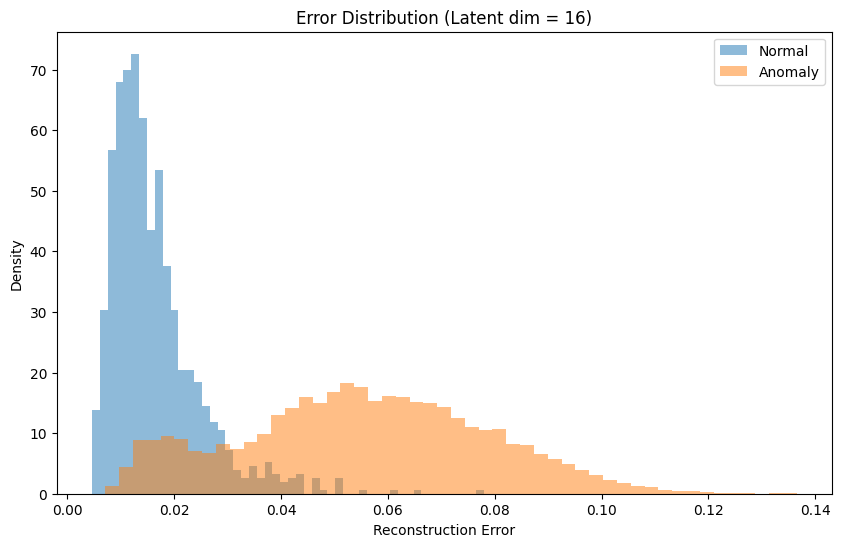

AUC-ROC Score for latent_dim=16: 0.9434

Training model with latent dimension: 32
Epoch [10/50], Loss: 0.029483
Epoch [20/50], Loss: 0.020954
Epoch [30/50], Loss: 0.016001
Epoch [40/50], Loss: 0.013892
Epoch [50/50], Loss: 0.012037

Performance metrics for latent_dim=32:
Precision: 0.9945
Recall: 0.8040
F1-score: 0.8891
Threshold: 0.0337


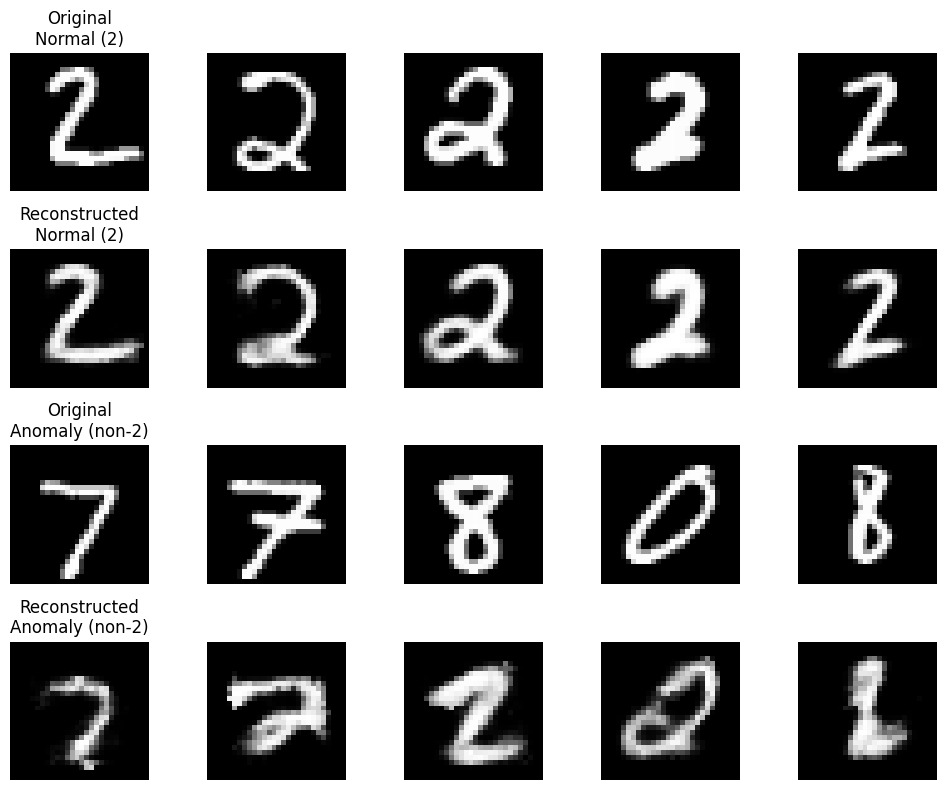

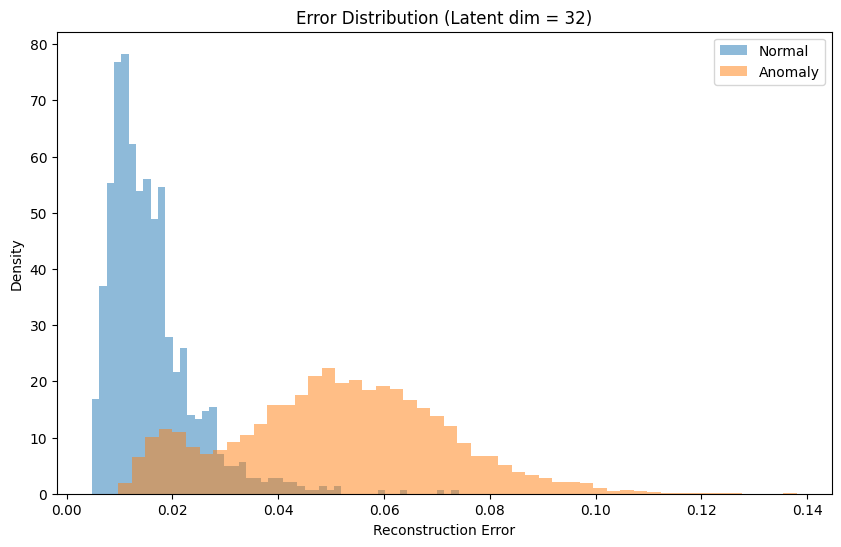

AUC-ROC Score for latent_dim=32: 0.9525

Training model with latent dimension: 64
Epoch [10/50], Loss: 0.030153
Epoch [20/50], Loss: 0.022916
Epoch [30/50], Loss: 0.016589
Epoch [40/50], Loss: 0.013914
Epoch [50/50], Loss: 0.011939

Performance metrics for latent_dim=64:
Precision: 0.9940
Recall: 0.7967
F1-score: 0.8845
Threshold: 0.0325


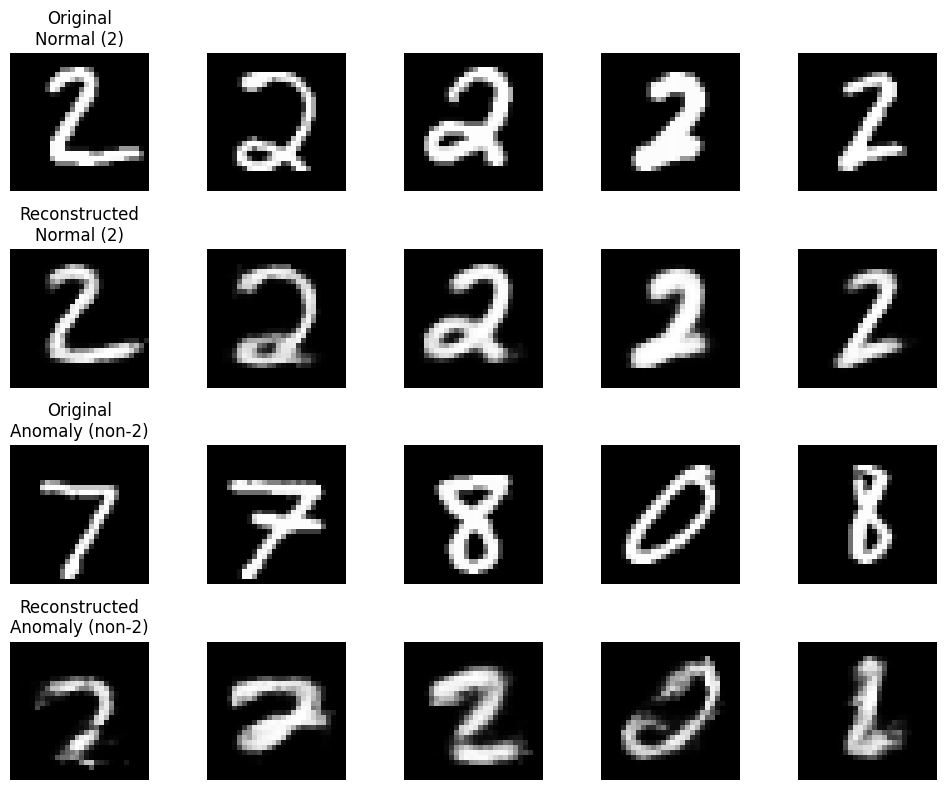

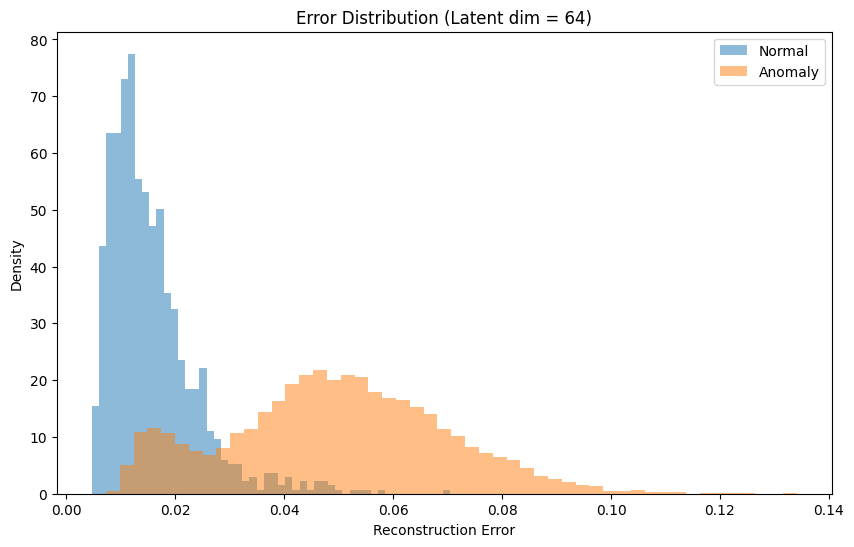

AUC-ROC Score for latent_dim=64: 0.9416

Best performing model has latent_dim=32 with AUC-ROC=0.9525


In [15]:
latent_dims = [16, 32, 64]
results = {}

for latent_dim in latent_dims:
    print(f"\nTraining model with latent dimension: {latent_dim}")
    fpr, tpr, roc_auc, test_errors, test_labels, metrics = train_and_evaluate(
        latent_dim=latent_dim,
        train_loader=train_loader,
        test_loader=test_loader,
        input_dim=input_dim,
        num_epochs=num_epochs,
        normal_digit=normal_digit,
        device=device
    )
    results[latent_dim] = (fpr, tpr, roc_auc, metrics)
    
    normal_errors = test_errors[test_labels == normal_digit]
    anomaly_errors = test_errors[test_labels != normal_digit]
    
    plt.figure(figsize=(10, 6))
    plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomaly', density=True)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title(f'Error Distribution (Latent dim = {latent_dim})')
    plt.legend()
    plt.savefig(f'reconstruction_errors_dim_{latent_dim}.png')
    plt.show()
    plt.close()
    
    print(f"AUC-ROC Score for latent_dim={latent_dim}: {roc_auc:.4f}")


best_dim = max(results.keys(), key=lambda k: results[k][2])
print(f"\nBest performing model has latent_dim={best_dim} with AUC-ROC={results[best_dim][2]:.4f}")


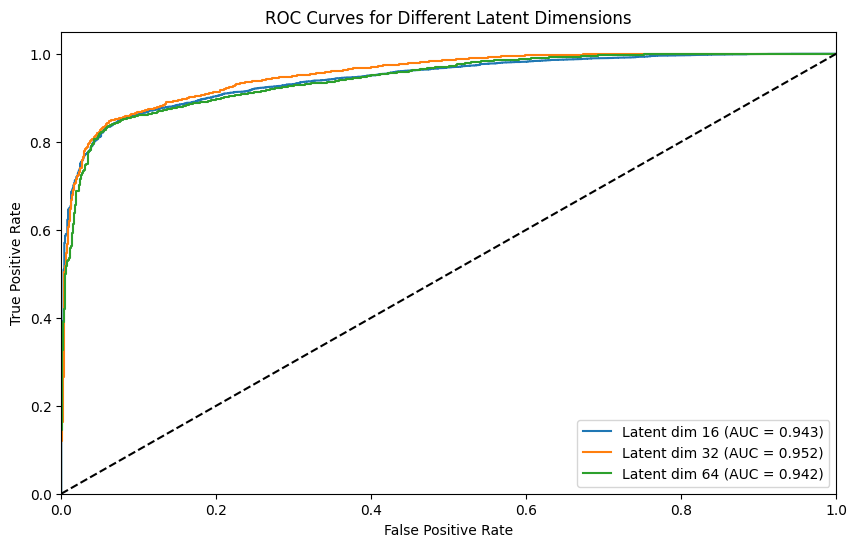

In [16]:
plot_roc_curves(results)

In [17]:
print("\nFinal comparison of all models:")
print("Latent Dim | AUC-ROC | Precision | Recall | F1-Score")
print("-" * 55)
for dim, (_, _, roc_auc, (precision, recall, f1, _)) in results.items():
    print(f"{dim:^10d} | {roc_auc:.4f} | {precision:.4f} | {recall:.4f} | {f1:.4f}")


Final comparison of all models:
Latent Dim | AUC-ROC | Precision | Recall | F1-Score
-------------------------------------------------------
    16     | 0.9434 | 0.9943 | 0.7914 | 0.8813
    32     | 0.9525 | 0.9945 | 0.8040 | 0.8891
    64     | 0.9416 | 0.9940 | 0.7967 | 0.8845
